# Open Food Facts - Cleanse data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Explore-the-data" data-toc-modified-id="Explore-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Explore the data</a></span><ul class="toc-item"><li><span><a href="#Display-number-of-non-NaN-entries-per-column" data-toc-modified-id="Display-number-of-non-NaN-entries-per-column-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Display number of non-NaN entries per column</a></span></li></ul></li><li><span><a href="#Cleanse-data" data-toc-modified-id="Cleanse-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cleanse data</a></span><ul class="toc-item"><li><span><a href="#Unitize-tags" data-toc-modified-id="Unitize-tags-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Unitize tags</a></span><ul class="toc-item"><li><span><a href="#Countries-tags" data-toc-modified-id="Countries-tags-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Countries tags</a></span></li><li><span><a href="#Labels-tags" data-toc-modified-id="Labels-tags-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Labels tags</a></span></li><li><span><a href="#Store-labels-tags" data-toc-modified-id="Store-labels-tags-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Store labels tags</a></span></li><li><span><a href="#Food-category-tags" data-toc-modified-id="Food-category-tags-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Food category tags</a></span></li></ul></li></ul></li><li><span><a href="#Carbon-footprint-dataset" data-toc-modified-id="Carbon-footprint-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Carbon footprint dataset</a></span><ul class="toc-item"><li><span><a href="#Loading-the-data" data-toc-modified-id="Loading-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Loading the data</a></span></li></ul></li><li><span><a href="#Concat-price-info" data-toc-modified-id="Concat-price-info-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Concat price info</a></span><ul class="toc-item"><li><span><a href="#OpenFoodFacts-dataset" data-toc-modified-id="OpenFoodFacts-dataset-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>OpenFoodFacts dataset</a></span></li><li><span><a href="#Carbon-footprint-dataset" data-toc-modified-id="Carbon-footprint-dataset-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Carbon footprint dataset</a></span></li></ul></li><li><span><a href="#Remove-negative-entries" data-toc-modified-id="Remove-negative-entries-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Remove negative entries</a></span></li><li><span><a href="#Write-clean-data-frame-to-CSV-file" data-toc-modified-id="Write-clean-data-frame-to-CSV-file-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Write clean data frame to CSV file</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

import json
import pickle

# Our generated code
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
from libs import exploring as explore
from libs import visualising as visualize
from libs import cleansing as cleanse

PLOT = True
RUN = False

In [2]:
# Import data
open_food_facts_csv_file = "./data/en.openfoodfacts.org.products.csv"

# Load list of columns (external file) that are loaded into pyspark
data = []
with open("./data/cleanse/columns_to_import.txt", "r") as json_data:
    columns_to_import = json.load(json_data)
    columns_to_import


food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t",
                            usecols=columns_to_import.keys(),
                            dtype=columns_to_import)

food_facts_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691256 entries, 0 to 691255
Data columns (total 22 columns):
code                         691222 non-null object
created_t                    691252 non-null object
created_datetime             691246 non-null object
product_name                 664958 non-null object
quantity                     192451 non-null object
packaging                    139026 non-null object
brands                       462717 non-null object
categories_en                177998 non-null object
origins                      41700 non-null object
origins_tags                 41646 non-null object
manufacturing_places         66476 non-null object
manufacturing_places_tags    66456 non-null object
labels_en                    101568 non-null object
purchase_places              99881 non-null object
stores                       90405 non-null object
countries_en                 690647 non-null object
ingredients_text             392561 non-null object
main_catego

In [3]:
data_summary_string = "The dataset now comprises {} entries, of which we have {} features."
data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1])

'The dataset now comprises 691256 entries, of which we have 22 features.'

## Explore the data
We begin with taking a quick look on the raw data.

In [4]:
food_facts_pd.head(5)

,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,origins,origins_tags,...,labels_en,purchase_places,stores,countries_en,ingredients_text,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000000017,1529059080,2018-06-15T10:38:00Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,1569.0,NaN,NaN,NaN
1,0000000000031,1539464774,2018-10-13T21:06:14Z,Cacao,130 g,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,1535737982,2018-08-31T17:53:02Z,Sauce Sweety chili 0%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,88.0,NaN,NaN,NaN
3,0000000000291,1534239669,2018-08-14T09:41:09Z,Mendiants,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000949,1523440813,2018-04-11T10:00:13Z,Salade de carottes râpées,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,134.0,NaN,NaN,NaN


### Display number of non-NaN entries per column

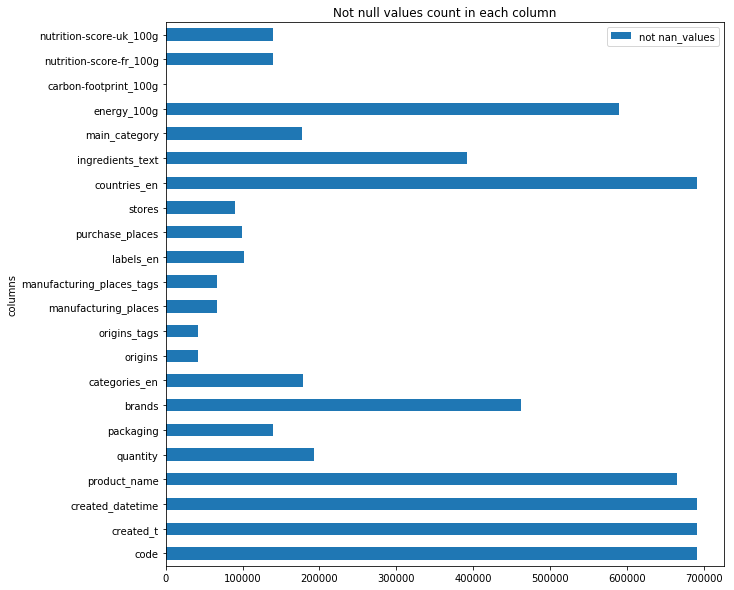

In [5]:
null_entries = pd.DataFrame({'columns' : food_facts_pd.columns,
                             'not nan_values' : [food_facts_pd[c].count() for c in food_facts_pd]
                            })

# Plot NaNs counts
if PLOT:
    null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
    plt.title("Not null values count in each column")
    plt.show()

We can observe that there are many entries are missing in this data set. Especially the *carbon-foorprint_100g* column is almost empty.

Let's also look at the dataset growth over the years:

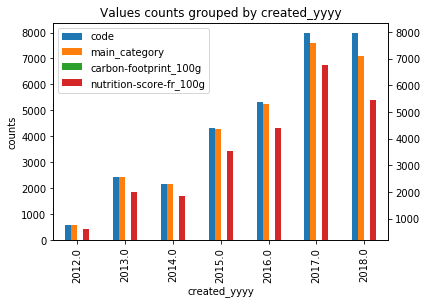

In [7]:
if PLOT:
    food_facts_pd['created_datetime'] = food_facts_pd['created_datetime'].apply(pd.to_datetime, args=('coerce',))
    food_facts_pd['created_yyyy'] = food_facts_pd["created_datetime"].dt.year
    visualize.plot_grouped_counts(food_facts_pd, 'created_yyyy', 
                                  ['code', 'main_category', 'carbon-footprint_100g', 'nutrition-score-fr_100g'])

The code line in the above plot denotes the overall count of entries that was created in the respective year. We can see that the popularity of the database has strongly increased over the past years, where the first mobile applications to use the database emerged. We only considered products that were created up to November 2018, which should be attributed to the decline in growth in this year.

We can further observe that the categorization and nutrition score computation of products develops disproportionately lower than the number of products, and is more complete for products that are in the database longer.

For our analysis, we can only use entries that have at least a product name, country tag, manufacturing and purchase place, store, and a created date tag. Unfortunately, we have to drop all columns, that lack these entries.

In [8]:
no_rows_inital = food_facts_pd.shape[0]

# Drop entries with missing entries in one of our main-features
essential_columns = ['created_t', 
                     'product_name', 
                     'countries_en', 
                     'categories_en', 
                     'stores',
                     'manufacturing_places', 
                     'purchase_places']
food_facts_pd = food_facts_pd.dropna(subset=essential_columns, )

no_rows_reduced_nan = food_facts_pd.shape[0]

# Also drop duplicated values (indentify based on index (barcode))
food_facts_pd = food_facts_pd.drop_duplicates()

no_rows_reduced_duplicates = food_facts_pd.shape[0]

print("{} entries were dropped, {} of those were duplicates."\
      .format(no_rows_inital-no_rows_reduced_duplicates, 
              no_rows_reduced_nan-no_rows_reduced_duplicates)
     )
print(data_summary_string.format(food_facts_pd.shape[0], 
                                 food_facts_pd.shape[1]))

650317 entries were dropped, 1 of those were duplicates.
The dataset now comprises 40939 entries, of which we have 23 features.


Puhh, that was though. From now on, we are going to rescue the data and enrich wherever we can.

In [9]:
# Replace NaNs with emptry string
food_facts_pd = food_facts_pd.fillna("")

Another thing that we are not really keen of are the language indicators, so we are going to remove those prefixes.

In [10]:
food_facts_pd.categories_en = food_facts_pd.categories_en.apply(cleanse.remove_language_indicator)
food_facts_pd.main_category = food_facts_pd.main_category.apply(cleanse.remove_language_indicator)
food_facts_pd.countries_en = food_facts_pd.countries_en.apply(cleanse.remove_language_indicator)
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(cleanse.remove_language_indicator)

## Cleanse data

### Unitize tags
Many parts of the data are categorizations based on tags. However, those tags are in a variety of languages and string formattings, so in order to use them we attempt to group tags that hint to the same property and map them to a common indicator. 

Every column of the data set requires special treatment, as follows:

#### Countries tags

Note :  
- purchase_places and countries_en are the same though "countries_en" has more entries
- manufacturing_places and origins are different

"_Countries_" is a csv file modified in the "_Country__names.ipynb_" file from the source (available at https://mledoze.github.io/countries/) that maps country names in a multitude of languages to their English counterpart. We need to harmonise country names (and push them to English since many entries use French and German). The columns requiring our attentions are the following:
- origins
- manufacturing_places
- countries_en

Note that each have a respective redundant column : origins_tags, manufacturing_places_tags and purchase_places. We are going to filter and group those by a function in our _cleansing.py_ library.

In [11]:
# Load analyse file
countries = pd.read_csv("./data/country_lookup.csv")[['name', 'cca2', 'alias', 'Forced']]

Now let's attack the Open Food Fact database

In [12]:
# The following commands are only run on demand, if the analysis has to be performed again. 
# The result are cached in ./data/food_facts_pd_countries_names.csv
RUN = False

In [13]:
if( RUN ):
    food_facts_pd['origins_cleaned'] = food_facts_pd.origins\
        .apply(lambda x: cleanse.tag_filter(x, countries))

In [14]:
if( RUN ):
    food_facts_pd['manufacturing_place_cleaned'] = food_facts_pd.manufacturing_places\
        .apply(lambda x: cleanse.tag_filter(x, countries))

In [15]:
if( RUN ):
    food_facts_pd['purchase_places_cleaned'] = food_facts_pd.purchase_places\
        .apply(lambda x: cleanse.tag_filter(x, countries))

In [16]:
# Cache results
if( RUN ):
    food_facts_pd_countries_names = food_facts_pd[['origins_cleaned', 
                                                   'manufacturing_place_cleaned', 
                                                   'purchase_places_cleaned']
                                                 ]
    food_facts_pd_countries_names.to_csv("./data/food_facts_pd_countries_names.csv")

#### Labels tags
The harmonisation of label tags is provided on the [OpenFoodFacts website](https://en.wiki.openfoodfacts.org/Global_labels_taxonomy).

In [17]:
# Unitze labels
with open('./data/cleanse/taxonomies.json', 'r') as json_data:
    labels_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.labels_en = food_facts_pd.labels_en.\
    apply(lambda x: ",".join([labels_lookup[z] for z in x.split(',')]))

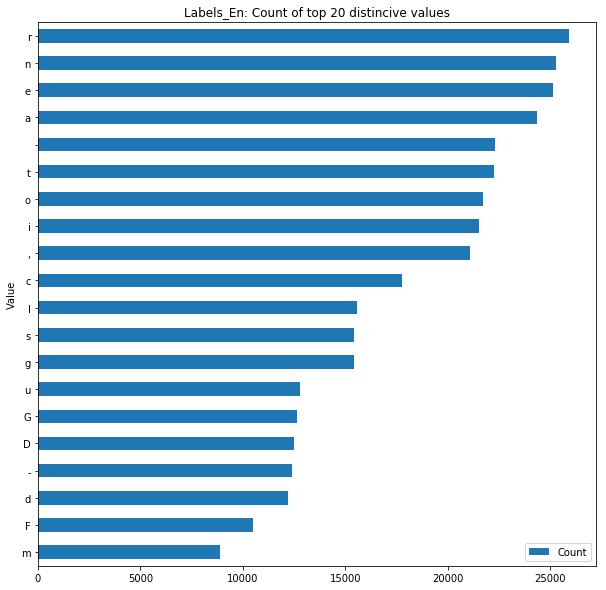

In [18]:
if PLOT:
    food_facts_pd['labels_en'] = food_facts_pd.labels_en\
        .apply(lambda x: cleanse.clean_tags_for_regex(x))
    _ = visualize.plot_occurrences_of_distinct_values(food_facts_pd, 'labels_en')

#### Store labels tags

In [19]:
# Unitize store labels
with open('./data/cleanse/stores_lookup.json', 'r') as json_data:
    stores_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.stores = food_facts_pd.stores.fillna("")\
    .apply(lambda x: ",".join([stores_lookup[z] for z in x.split(',')]))

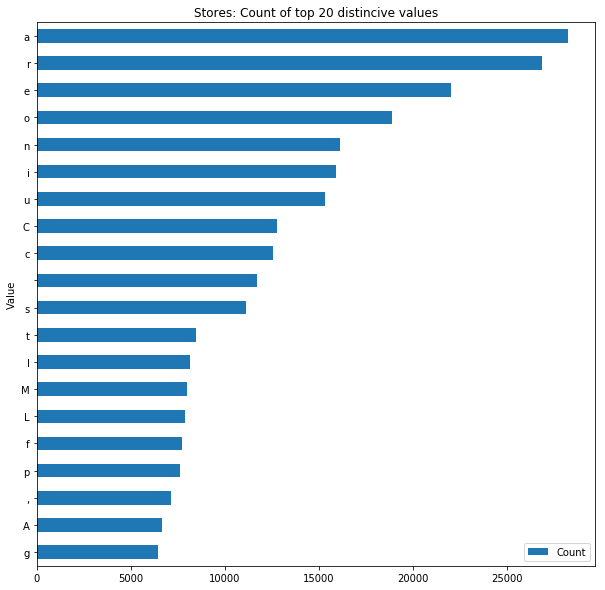

In [20]:
if PLOT:
    food_facts_pd['stores'] = food_facts_pd.stores\
        .apply(lambda x: cleanse.clean_tags_for_regex(x))
    _ = visualize.plot_occurrences_of_distinct_values(food_facts_pd, 'stores')

#### Food category tags
For the food category, we used human intelligence to assign subcategory to a theme based on their main ingredient.

In [21]:
# Group categories by user-defined themes
with open('./data/cleanse/categories_en_lookup.json', 'r') as json_data:
    categories_en = json.load(json_data)
categories_en_lookup = cleanse.to_lookup(categories_en)
food_facts_pd.main_category = food_facts_pd.categories_en.\
    apply(cleanse.group_categories, args=[categories_en_lookup]).\
    apply(cleanse.filter_others, args=[list(categories_en.keys())])  

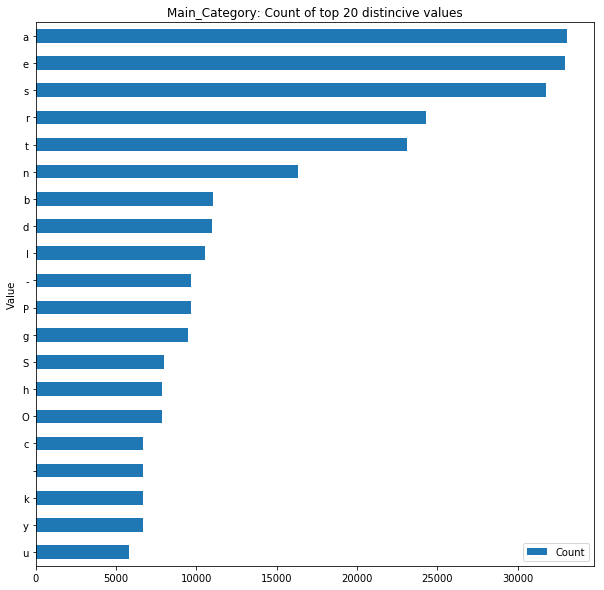

In [22]:
if PLOT:
    _ = visualize.plot_occurrences_of_distinct_values(food_facts_pd, 'main_category')

## Carbon footprint dataset

Because the food facts database lacks carbon footprint specifications, we got random samples of products from Eaternity database. Unfortunately, we were not allowed access to the API before purchasing a 2000 CHF license. However, we were granted a dataset of carbon footprints for a random subset of products. These products have complete carbon footprint support, but therefore lack indication of production and purchasing countries as well as ingredients for computing the nutrition grades.

Let's still take a quick look at the Carbon Footprint database, that we have obtained.

### Loading the data

In [23]:
# Import data
carbon_footprint_categories_csv_file = "./data/carbon_footprint_categories.csv"

eaternity_pd = pd.read_csv(carbon_footprint_categories_csv_file,delimiter='\t')

In [24]:
# Match categories to the same themes as for the OpenFoodFacts
with open('./data/cleanse/categories_en_lookup.json', 'r') as json_data:
    categories_en = json.load(json_data)

# Group categories by themes
categories_en_lookup = cleanse.to_lookup(categories_en)
eaternity_pd['category_en'] = eaternity_pd.category_en.\
    apply(cleanse.group_categories, args=[categories_en_lookup]).\
    apply(cleanse.filter_others, args=[list(categories_en.keys())])   

In [25]:
# Rename columns to OpenFoodFacts correspondences
eaternity_pd.rename(columns={'Title':'product_name',
                            'CO2-Value [gram CO2/serving]':'carbon-footprint_100g',
                            'ENERC':'energy_100g', 
                            'category_en' : 'main_category'},
                             inplace=True)

In [26]:
print('We have {0} ecological features for {1} products.'\
      .format(eaternity_pd.shape[1], 
              eaternity_pd.shape[0]))

We have 21 ecological features for 682 products.


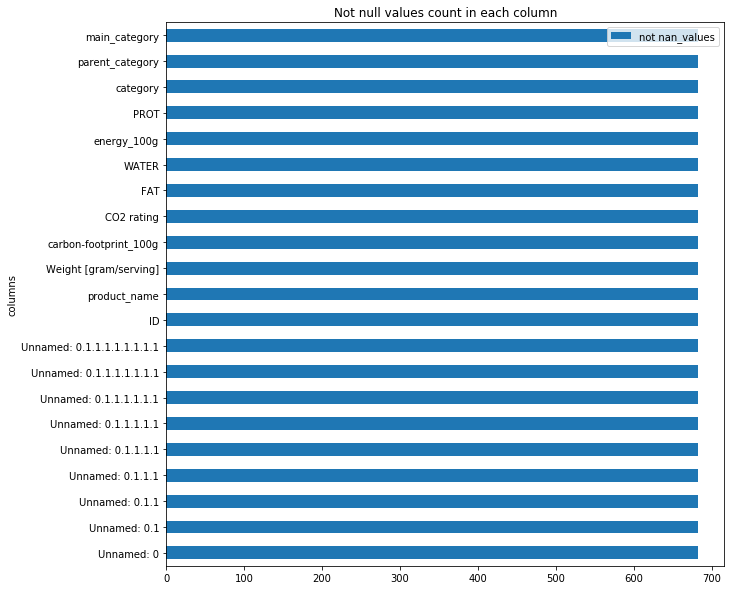

In [27]:
null_entries = pd.DataFrame({'columns' : eaternity_pd.columns,
                             'not nan_values' : [eaternity_pd[c].count() for c in eaternity_pd]
                            })

# Plot NaNs counts
if PLOT:
    null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
    plt.title("Not null values count in each column")
    plt.show()

We clearly see that all the columns of the carbon footprint database from Eaternity are complete.

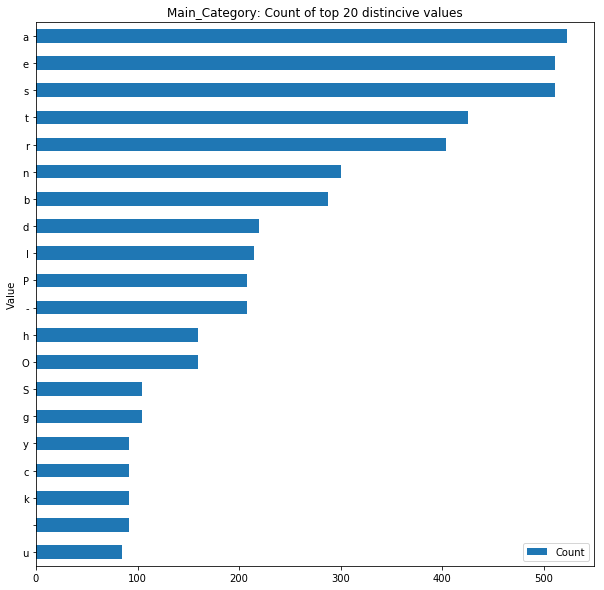

In [28]:
if PLOT:
    _ = visualize.plot_occurrences_of_distinct_values(eaternity_pd, 'main_category')

Looking at the categories, there are mainly vegetables and condiments. Once we will match with the Open Food Facts database, we will have carbon footprint of food/meals derived from vegetables.

In [29]:
# ax = eaternity_pd['CO2-Value [gram CO2/serving]'].hist(bins=10)
# ax.set_xlabel('Carbon footprint')
# ax.set_ylabel('Occurencies')
# ax.set_title('Distribution of the carbon ')

We are interested in the carbon footprint of each product. Because our sample is small (around 700 products) and doesn't really match with the Food Facts Database, we will take care of the categories. Thus, we will extract the categories from [Codecheck website](https://www.codecheck.info/) (Webscraper).

## Concat price info

We also searched online shops for price information about some of the products, that we are going to merge in the following.

### OpenFoodFacts dataset

In [30]:
prices = pd.read_csv("./web_crawler/data/prices_carbon.csv", dtype={'code':object})

In [31]:
prices_reduced = prices[['product_name', 'price_per_100g', 'store_currency']]

Because the OpenFoodFacts code is not necessarily a global barcode for the product, we had to match the products from the online stores and the entries of the database by teh product name. To be consistent with that method, we merge the prices by the product name.

In [32]:
food_facts_pd = pd.merge(food_facts_pd, prices_reduced, on='product_name', how='left')

In [33]:
print("Product prices successfully merged: {}".format(food_facts_pd.price_per_100g.count()))

Product prices successfully merged: 173


### Carbon footprint dataset
The same process, we repeated for the Eaternity dataset.

In [34]:
prices = pd.read_csv("./web_crawler/data/prices.csv", dtype={'code':object})
prices_reduced = prices[['product_name', 'price_per_100g', 'store_currency']].dropna()
eaternity_pd = pd.merge(eaternity_pd, prices_reduced, on='product_name', how='left')

In [35]:
print("Product prices successfully merged: {}".format(eaternity_pd.price_per_100g.count()))

Product prices successfully merged: 447


## Remove negative entries
We have few numerical features, which are the calories (energy), and price per 100g of the product. These values are due to physical or economic laws non-negative and hence corrupted, which is why we are going to make sure of this in the following.

In [36]:
# numeric_columns = food_facts_pd.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

# food_facts_pd[numeric_columns] = food_facts_pd[numeric_columns].where(food_facts_pd[numeric_columns] >= 0, np.NaN)

## Write clean data frame to CSV file

Note : country names harmonised are available in ./data/food_facts_pd_countries_names.csv (note the additional code to go back to a list of strings). 

In [37]:
# Apply country name filter

# Load lookup file
countries_names= pd.read_csv("./data/food_facts_pd_countries_names.csv")

countries_names['origins_cleaned'] = \
                        countries_names.origins_cleaned.apply(lambda l: cleanse.read_list_from_str(l))

countries_names['manufacturing_place_cleaned'] = \
                        countries_names.manufacturing_place_cleaned.apply(lambda l: cleanse.read_list_from_str(l))

countries_names['purchase_places_cleaned'] = \
                        countries_names.purchase_places_cleaned.apply(lambda l: cleanse.read_list_from_str(l))

food_facts_pd = food_facts_pd.drop(['countries_en',
                                   'origins_tags', 
                                    'manufacturing_places_tags',
                                    'purchase_places'],
                                    axis=1)

food_facts_pd['origins'] = countries_names.origins_cleaned
food_facts_pd['manufacturing_places'] = countries_names.manufacturing_place_cleaned
food_facts_pd['purchase_places'] = countries_names.purchase_places_cleaned
food_facts_pd.head(2)


,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,origins,manufacturing_places,...,ingredients_text,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,created_yyyy,price_per_100g,store_currency,purchase_places
0,0000000274722,1514659309,2017-12-30 18:41:49,Blanquette de Volaille et son Riz,,"carton,plastique",Comme J’aime,"Meals,Meat-based products,Meals with meat,Poul...",France,France,...,"Riz précuit 40,4 % (eau, riz, huile de colza, ...",Meats,450,,0,0,2017,NaN,NaN,France
1,0000000394710,1484497370,2017-01-15 16:22:50,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",Canada,Unknown,...,"Ingrédients: Pâte (farine, eau, beurre, sucre,...",Sugary snacks,1520,,,,2017,NaN,NaN,Unknown


In [38]:
# Last touch - be frank about unknown countries
food_facts_pd[['origins', 'manufacturing_places', 'purchase_places']] = \
    food_facts_pd[['origins', 'manufacturing_places', 'purchase_places']].fillna("Unknown")

In [39]:
# Write cleaned datasets to CSV file
clean_data_file_name = "./data/openfoodfacts_clean.csv"
food_facts_pd.to_csv(clean_data_file_name, sep='\t', encoding='utf-8')

processed_carbon_data_file_name = "./data/carbon_footprint_clean.csv"
eaternity_pd.to_csv(processed_carbon_data_file_name, sep='\t', encoding='utf-8', index=False)